hologram_number,xsize,ysize


In [2]:
import numpy as np
import xarray as xr
import pandas as pd
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Activation, MaxPool2D
from tensorflow.keras.models import Model, save_model
from scipy.fftpack import fft2, ifft2
from tensorflow.keras.optimizers import Adam
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/ncar/usr/jupyterhu

In [3]:
ds = xr.open_dataset("synthetic_holograms_v01 (2).nc")
print(ds.dims)

Frozen(SortedKeysDict({'particle': 10000, 'hologram_number': 10000, 'xsize': 600, 'ysize': 400}))


In [4]:
split_index = 7000
all_labels = ds[["x", "y", "z", "d"]].to_dataframe()
train_labels = all_labels.iloc[:split_index]
test_labels = all_labels.iloc[split_index:]
scaler = MinMaxScaler()
scaled_train_labels = pd.DataFrame(scaler.fit_transform(train_labels), index=train_labels.index, columns=train_labels.columns)
scaled_test_labels = pd.DataFrame(scaler.transform(test_labels), index=test_labels.index, columns=test_labels.columns)

In [5]:
in_data = ds["image"]
ds["image"].dims

('hologram_number', 'xsize', 'ysize')

In [6]:
scaled_in_data = in_data.astype(np.float16) / 255
scaled_in_data.dtype

dtype('float16')

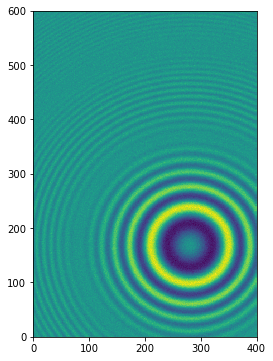

In [7]:
index = 12
plt.figure(figsize=(4, 6))
plt.pcolormesh(scaled_in_data[split_index + index])
#plt.scatter(scaled_test_labels.iloc[index, 1] * 400, scaled_test_labels.iloc[index, 0] * 600, 2 * test_labels.iloc[index, -1], 'r')
#plt.scatter(preds_out[split_index + index, 1] * 400, preds_out[split_index + index, 0] * 600, 2 * preds_original[split_index + index, -1], 'b')

Orginal Colormesh of Data Before the Transformation

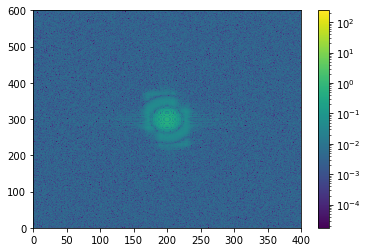

In [9]:
fout = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(scaled_in_data[split_index + index])))/np.sqrt(np.size(scaled_in_data[split_index + index]))
image = plt.pcolormesh(np.abs(fout),norm = colors.LogNorm())
plt.colorbar(image)


Image of Transformed Particle, using a logscale for better visibility

In [ ]:
#pass everything out of the x array into this code
out_data = []
for i in range(10000):
    out_data.append(np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(scaled_in_data[i])))/np.sqrt(np.size(scaled_in_data[i])))
dnew = xr.DataArray(out_data,coords=ds.coords, dims=("hologram_number","xsize","ysize"),attrs=ds.attrs,name="synthetic_hologram_FFT")
dnew.to_netcdf("synthetic_hologram_FFT-Transform_v0.nc",'w','NETCDF4',encoding = {'xsize':{'dtype': 'float16','zlib': True},'ysize':{'dtype': 'float16','zlib': True}})
#dnew.to_netcdf("synthetic_hologram_FFT-Transform_v0.nc",'w','NETCDF4',encoding ={'xsize':{'zlib': True},'ysize':{'zlib': True}})

NETCDF4 is compression 
to_net
save as float16

In [ ]:
ds = xr.open_dataset("synthetic_hologram_FFT-Transform_v0.nc")

In [18]:
Aout = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(Ain)))/np.sqrt(np.size(Ain))

{'DateCreated': '29-Oct-2019',
 'Nx': 600.0,
 'Ny': 400.0,
 'dx': 2.96e-06,
 'dy': 2.96e-06,
 'lambda': 3.55e-07,
 'Dpmin': 2e-05,
 'Dpmax': 7e-05,
 'zMin': 0.014,
 'zMax': 0.158,
 'NParticles': 1.0,
 'Nbits': 8.0,
 'ccdelevel': 20000.0,
 'gainFactor': 24.0,
 'readNoiseSTD': 12.0,
 'gaussCornCon': 1.0,
 'lowPassFiltCutoff': 2500.0,
 'fracBeamDistort': 0.02,
 'should_beam': 1,
 'should_noise': 1,
 'should_lnoise': 0,
 'partRelInt': 0.5,
 'nHolograms': 10000.0,
 'makeRandParts': 1,
 'should_random': 1,
 'should_extend_domain': 0,
 'superSamplingRate': 1.0,
 'should_cache': 1}

FFT Shift for the Multi-Particle CDF